# 双極子データの解析

## 2024/2/17 :: スペクトルを慣性軸に分解して計算する！！（遂に）

計算の過程としては以下の二段階のステップを踏む必要がある．

  1: 各timestepでの慣性軸ベクトルを計算して保持する
  2: 慣性軸ベクトルに双極子を射影する．

https://qiita.com/mimitaro/items/9fa7e054d60290d13bfc
https://qiita.com/Broccolingual/items/9838443aa6838a867041
https://qiita.com/knknkn1162/items/87b1153c212b27bd52b4
https://docs.python-guide.org/writing/logging/#example-configuration-directly-in-code

In [1]:
from logging import getLogger, StreamHandler, Formatter, DEBUG, INFO, WARNING, CRITICAL
# create logger
logger = getLogger('simple_example')
logger.setLevel(DEBUG)

# create console handler and set level to debug
ch = StreamHandler()
ch.setLevel(DEBUG)

# create formatter
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

# from logging import getLogger, Formatter, StreamHandler, FileHandler, DEBUG, INFO

# def get_module_logger(module, verbose):
#     logger = getLogger(module)
#     logger = _set_handler(logger, StreamHandler(), False)
#     logger = _set_handler(logger, FileHandler(LOG_DIR), verbose)
#     logger.setLevel(DEBUG)
#     logger.propagate = False
#     return logger

# def _set_handler(logger, handler, verbose):
#     if verbose:
#         handler.setLevel(DEBUG)
#     else:
#         handler.setLevel(INFO)
#     handler.setFormatter(Formatter('%(asctime)s %(name)s:%(lineno)s %(funcName)s [%(levelname)s]: %(message)s'))
#     logger.addHandler(handler)
#     return logger

In [2]:
# 'application' code
logger.debug('debug message')
logger.info('info message')
logger.warning('warn message')
logger.error('error message')
logger.critical('critical message')


2024-03-22 07:59:33,391 - simple_example - DEBUG - debug message
2024-03-22 07:59:33,392 - simple_example - INFO - info message
2024-03-22 07:59:33,392 - simple_example - WARNING - warn message
2024-03-22 07:59:33,392 - simple_example - ERROR - error message
2024-03-22 07:59:33,393 - simple_example - CRITICAL - critical message


In [3]:
# 物理定数
from include.constants import constant  
# Debye   = 3.33564e-30
# charge  = 1.602176634e-019
# ang      = 1.0e-10 
coef    = constant.Ang*constant.Charge/constant.Debye 

In [4]:
import ase
import ase.io


import ase
import ase.io


# liquidのデータを読み込み（128分子分）
traj_liquid = ase.io.read("../traj/mol_wan_1.xyz",index="600:100600")

# # liquidのデータを読み込み
# traj_list = []
# traj_list.append(ase.io.read("../traj/mol_wan_1.xyz",index="600:100600"))
# traj_list.append(ase.io.read("../traj/mol_wan_3.xyz",index="600:100600"))
# traj_list.append(ase.io.read("../traj/mol_wan_6.xyz",index="6000:106000"))
# traj_list.append(ase.io.read("../traj/mol_wan_7.xyz",index="100000:200000"))
# traj_list.append(ase.io.read("../traj/mol_wan_8.xyz",index="100000:200000"))
# traj_list.append(ase.io.read("../traj/mol_wan_7.xyz",index=":100000"))
# traj_list.append(ase.io.read("../traj/mol_wan_8.xyz",index=":100000"))



#
# 液体モデルで，角速度ACFを計算したい．

- 分子に対して慣性モーメントから主軸を計算する（x1,x2,x3）
- このうち，メタノールの場合はCOに対応する軸が主軸となるイメージ．

# 慣性モーメントテンソルの定義

https://www.sky-engin.jp/blog/inertia-matrix/#toc7
https://www.physics.arizona.edu/~varnes/Teaching/321Fall2004/Notes/Lecture34.pdf
https://eman-physics.net/dynamics/mom_tensor.html
https://web.chem.ox.ac.uk/teaching/Physics%20for%20CHemists/Rotation/3d.html
https://www2.kobe-u.ac.jp/~lim/kako-kougi-pdf/goutai2.pdf
https://ja.wikipedia.org/wiki/%E6%85%A3%E6%80%A7%E3%83%A2%E3%83%BC%E3%83%A1%E3%83%B3%E3%83%88

まず，ベクトル$a=(x,y,z)$に対するチルダ行列を
$$
\tilde{a}=
\begin{pmatrix}
0 & -z & y \\
z &  0 & -x \\
-y & x & 0 \\
\end{pmatrix}
$$
と定める．これは反対称行列．これを用いて，慣性モーメントテンソルは
$$
I = \sum_{i}m_{i}\tilde{rho}\tilde{rho} 
$$
と定義できる．

これはちょっとわかりにくいので，より直接的な定義を用いると
$$
I_{ij} = \sum_{k}m_{k}\left(\left(r^{k}\right)^2\delta_{ij}-r^{k}_{i}r^{k}_{j} \right)
$$
となる．$r$は座標の距離を表し，
$$
r^2=x^2+y^2+z^2
$$
とする．したがって，対角成分は例えばxx成分は$y^2+z^2$などを計算する．非対角成分は$-x_ix_j$という簡単な形になる．

ここで，座標については注意が必要で，基本的には原点を分子の重心に取り直す必要がある．したがって，アルゴリズム上では，

- [DONE] 1フレームから分子座標を抽出
- [DONE] 分子座標&原子種類から重心座標を取得
- [DONE] 重心からの相対座標を計算
- [DONE] 相対座標を利用して慣性モーメントテンソルを計算
- [DONE] 慣性モーメントテンソルを対角化
  
というステップを踏む．まずはここまで実装する．@2024/1/19 20:18

対角化は完了した． @2024/1/19 21:17

次に，固有値が小さい順に成分を並べる必要がある．固有値が最も小さいのがメタノールのCO軸で，これは圧倒的なので区別がつく．ただし，二番目と三番目についてはその固有値の差が非常に微妙．woodsではy軸をCOH面内として，これが二番目に小さいのかと思ったが，そうではない可能性がある．
で，二番目に小さいのがCOH面内と思われるが，下手すると2,3番目は構造によって入れ替わる可能性がありそうなので，念の為チェックを入れた方が良いかも．

In [5]:
#
# * 慣性モーメントテンソル
import numpy as np

def calc_inertia_tensor(atoms:ase.atoms):
    """純粋に慣性モーメントテンソルの計算だけを実施する．

    Args:
        atoms (ase.atoms): 1分子のatoms
    """
    # 重心計算
    com:np.ndarray = atoms.get_center_of_mass()
    # 座標と原子量を取得．座標は重心を差し引く
    positions:np.ndarray      = atoms.get_positions() - com
    # logger.debug("positions :: {0}".format(positions))
    # print("positions ::",positions)
    # atomic_numbers:np.ndarray = atoms.get_atomic_numbers()
    atomic_masses:np.ndarray  = atoms.get_masses()
    # 慣性モーメントテンソルを計算
    diagonalterm = np.einsum("k,ki,ki->", atomic_masses, positions, positions)*np.eye(3,3) # mr^2に単位ベクトルをかけている
    crossterm    = np.einsum("k,ki,kj->ij", atomic_masses, positions, positions) # mr_ir_j
    # logger.debug("crossterm :: {0}".format(crossterm))
    inertiaTensor = diagonalterm-crossterm
    return inertiaTensor


def calc_inertia(atoms:ase.atoms):
    """慣性モーメントテンソルを対角化し，固有値の小さい順に固有ベクトルを出す

    Args:
        atoms (ase.atoms): _description_

    Returns:
        np.ndarray: _description_
    """
    # # 重心計算
    # com:np.ndarray = atoms.get_center_of_mass()
    # # 座標と原子量を取得．座標は重心を差し引く
    # positions:np.ndarray      = atoms.get_positions() - com
    # # logger.debug("positions :: {0}".format(positions))
    # # print("positions ::",positions)
    # # atomic_numbers:np.ndarray = atoms.get_atomic_numbers()
    # atomic_masses:np.ndarray  = atoms.get_masses()
    # # 慣性モーメントテンソルを計算
    # diagonalterm = np.einsum("k,ki,ki->", atomic_masses, positions, positions)*np.eye(3,3) # mr^2に単位ベクトルをかけている
    # crossterm    = np.einsum("k,ki,kj->ij", atomic_masses, positions, positions) # mr_ir_j
    # # logger.debug("crossterm :: {0}".format(crossterm))
    # inertiaTensor = diagonalterm-crossterm
    inertiaTensor = calc_inertia_tensor(atoms)
    logger.debug("慣性モーメントテンソル :: {0}".format(inertiaTensor))
    # 対角化
    eigen = np.linalg.eig(inertiaTensor)
    logger.debug("固有値 :: {0}".format(eigen[0]))
    logger.debug("固有ベクトル(転置してベクトルを取り出せるようにした) :: {0}".format(eigen[1].transpose()))
    # 固有値が小さい順（固有値が小さい=回りやすいので，分子の主鎖に近い順に並ぶ）
    eigenvector_sorted = eigen[1].transpose()[np.argsort(eigen[0])]  # 固有値e[0]の小さい順にソートし，そのインデックスを返す．それをe[1]に代入して並び替え．テスト済み．
    # 念の為，三番目の固有ベクトルを外積で計算する．
    eigenvector_sorted[2] = np.cross(eigenvector_sorted[0],eigenvector_sorted[1])
    return {"axis":eigenvector_sorted, "eigenval":np.sort(eigen[0])}  # 固有値と固有ベクトルを返す


def calc_inertia_old(atoms:ase.atoms) -> np.ndarray:
    """慣性モーメントテンソルを対角化し，固有値の小さい順に固有ベクトルを出す

    Args:
        atoms (ase.atoms): _description_

    Returns:
        np.ndarray: _description_
    """
    # 重心計算
    com:np.ndarray = atoms.get_center_of_mass()
    # 座標と原子量を取得．座標は重心を差し引く
    positions:np.ndarray      = atoms.get_positions() - com
    # logger.debug("positions :: {0}".format(positions))
    # print("positions ::",positions)
    # atomic_numbers:np.ndarray = atoms.get_atomic_numbers()
    atomic_masses:np.ndarray  = atoms.get_masses()
    # 慣性モーメントテンソルを計算
    diagonalterm = np.einsum("k,ki,ki->", atomic_masses, positions, positions)*np.eye(3,3) # mr^2に単位ベクトルをかけている
    crossterm    = np.einsum("k,ki,kj->ij", atomic_masses, positions, positions) # mr_ir_j
    # logger.debug("crossterm :: {0}".format(crossterm))
    inertiaTensor = diagonalterm-crossterm
    logger.debug("慣性モーメントテンソル :: {0}".format(inertiaTensor))
    # 対角化
    eigen = np.linalg.eig(inertiaTensor)
    logger.debug("固有値 :: {0}".format(eigen[0]))
    logger.debug("固有ベクトル(転置してベクトルを取り出せるようにした) :: {0}".format(eigen[1].transpose()))
    # 固有値が小さい順（固有値が小さい=回りやすいので，分子の主鎖に近い順に並ぶ）
    eigenvector_sorted = eigen[1].transpose()[np.argsort(eigen[0])]  # 固有値e[0]の小さい順にソートし，そのインデックスを返す．それをe[1]に代入して並び替え．テスト済み．
    # 念の為，三番目の固有ベクトルを外積で計算する．
    eigenvector_sorted[2] = np.cross(eigenvector_sorted[0],eigenvector_sorted[1])
    return eigenvector_sorted



def cos_similar(a:np.ndarray, b:np.ndarray) -> float:
    """二つのベクトルのなす角度を度数単位で計算

    Args:
        a (np.ndarray): _description_
        b (np.ndarray): _description_

    Returns:
        float: _description_
    """
    aa  = np.linalg.norm(a)
    bb  = np.linalg.norm(b)
    inn = np.inner(a,b) 
    return np.arccos(inn/(aa*bb))*180/np.pi




# 各フレームでの主慣性軸（inertia_axis），主慣性モーメント（inertia_eigenval），および原子のこの座標での値（coord_inertia）を計算

In [6]:
# 
# * 関数として慣性軸の計算を定義
# !! 注意：これはメタノール専用
def calc_inertia_axis_methanol(atoms:ase.Atoms):
    """calc_inertia関数の外側のwrapper

    calc_inertiaで計算した慣性軸を，メタノールの場合に合わせて符号反転させる．
    Args:
        atoms (ase.Atoms): 慣性軸を計算する分子

    Returns:
        _type_: _description_
    """
    # 各分子に対して慣性主軸を計算（これは共通）
    _raw_inertia = calc_inertia(atoms)
    mol_inertia = _raw_inertia["axis"]
    mol_inertia_eigenval = _raw_inertia["eigenval"]

    # 以下メタノール専用
    # 座標（重心を差し引く）
    positions:np.ndarray = atoms.get_positions()-atoms.get_center_of_mass()
    c_to_o = positions[1]-positions[0] # 0:C，1:O
    o_to_h = positions[5]-positions[1] # 1:O, 5:H
    # logger.debug("mol_inertia :: {0}".format(mol_inertia))
    if np.dot(mol_inertia[0],c_to_o) < 0: # COベクトルとの内積が負なら符号を逆転
        mol_inertia[0] = -mol_inertia[0]
    if np.dot(mol_inertia[1],o_to_h) < 0: # OHベクトルとの内積が負なら符号を逆転
        mol_inertia[1] = -mol_inertia[1]
    mol_inertia[2] = np.cross(mol_inertia[0], mol_inertia[1])
    return {"eigenval": mol_inertia_eigenval, "axis": mol_inertia}

In [7]:
#
# * 角速度ACFの計算のために，まずは各frameでの主慣性軸周りの座標を取得

logger.setLevel(INFO)
ch.setLevel(INFO)

def calc_inertia_traj(traj_liquid):
    # !! hard code
    NUM_MOL = 48
    NUM_ATOM_ALL = 17 # mol_WCの全原子数in 1分子
    NUM_ATOM     = 6  # 通常の原子数 in 1分子
    coord_inertia = np.empty([len(traj_liquid),NUM_MOL,NUM_ATOM,3]) #慣性主軸での座標
    inertia_axis  = np.empty([len(traj_liquid),NUM_MOL,3,3]) # 慣性主軸
    inertia_eigenval = np.empty([len(traj_liquid),NUM_MOL,3]) # 慣性モーメント（固有ベクトル）

    for counter,atoms in enumerate(traj_liquid): # frameに関するloop
        for mol_id in range(NUM_MOL): # 分子数に関するloop
            # atomsを取得
            # 17が全体のデータ，そのうち原子の6個だけを抽出
            atoms_sample = atoms[NUM_ATOM_ALL*mol_id:NUM_ATOM_ALL*mol_id+NUM_ATOM]
            # メタノールの慣性軸を計算
            met_inertia = calc_inertia_axis_methanol(atoms_sample)
            # 慣性主軸/モーメントを保存
            inertia_axis[counter,mol_id] = met_inertia["axis"]
            inertia_eigenval[counter,mol_id] = met_inertia["eigenval"]
            # 座標（重心を差し引く）
            positions:np.ndarray = atoms_sample.get_positions()-atoms_sample.get_center_of_mass()
            # 慣性主軸をベースとする座標を計算
            coord_inertia[counter, mol_id] = np.einsum("ai,ki->ak",positions,met_inertia["axis"])
    return coord_inertia, inertia_axis, inertia_eigenval


In [ ]:
# 
# * 

In [8]:
#
# * trajectoryの慣性軸計算
coord_inertia, inertia_axis, inertia_eigenval =  calc_inertia_traj(traj_liquid)

In [36]:
#
# * 原子速度の回転運動成分の計算
#
# - 


L = traj_liquid[0].get_cell()[0][0]
logger.info("Lattice parameter :: {0}".format(L))

NUM_MOL = 48
logger.setLevel(INFO)
ch.setLevel(INFO)
Dt = 0.484 # fs
NUM_ATOM_ALL = 17
NUM_ATOM     = 6

NUM_ATOM_WAN = 12 
# 速度リスト
velocity_list =np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])
# 重心からの相対速度のうち，距離ベクトルと直交する成分
atom_rotation_velocity = np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])

# 原子とWCだけ抽出（BCの情報は不要）
atoms_index = np.array([0,1,2,3,4,5,11,12,13,14,15,16])

for counter,atoms in enumerate(traj_liquid): # frameに関するloop 
    if counter == len(traj_liquid)-1: #最終フレームはskip
        break
    for mol_id in range(NUM_MOL): # 分子数に関するloop
        # 必要なのは，時間tでの相対座標と，時間t+dtでの相対座標なのは変わらない．
        # atomsを取得 (分子の重心計算用なので，原子のindexだけ必要)
        atoms_sample = atoms[NUM_ATOM_ALL*mol_id:NUM_ATOM_ALL*mol_id+NUM_ATOM]
        # 座標（重心を差し引く）
        positions:np.ndarray = atoms[NUM_ATOM_ALL*mol_id+atoms_index].get_positions()-atoms_sample.get_center_of_mass()
        #
        
        # 次のatomsを取得 (重心計算用)
        atoms_next = traj_liquid[counter+1][NUM_ATOM_ALL*mol_id:NUM_ATOM_ALL*mol_id+NUM_ATOM]
        # 座標（重心を差し引く）
        # 本来はt+dtでの相対座標が欲しいので，atoms_next.get_center_of_mass()を差し引くのが正しいと思う．
        # ただ，どちらで計算しても結果には大差ない．
        positions_next:np.ndarray = traj_liquid[counter+1][NUM_ATOM_ALL*mol_id+atoms_index].get_positions()-atoms_next.get_center_of_mass() 
        # >>>>>>>>>>>>>>>>>>>>>>>>>
        # 速度v =(r-r)/Dtで求めるにあたって，pbcをかける必要がある．
        # 座標の差分を計算（r'(t+dt)-r'(t))
        diff = positions_next - positions
        # pbcのチェック
        tmp = np.where(diff>L/2,diff-L,diff)
        diff_pbc = np.where(tmp<-L/2,tmp+L,tmp)        
        # 相対速度(NUM_ATOM, 3の成分) 
        # !! 単位に神経を使う．全てpsで計算する．
        velocity = diff_pbc/(Dt/1000)
        # >>>>>>>>>>>>>>>>>>>>>>>>>>
        # 原子別の速度のうち，positionsと直交する成分だけを取り出す
        # 平行(射影)成分は(v*R)R/|R|^2で取り出せる．
        positions_norm = np.einsum("i,ij -> ij",1/(np.linalg.norm(positions,axis=1)),positions)
        inner_product = np.einsum("ij, ij -> i",velocity,positions_norm) # v*R/|R|
        parallel_velocity = np.einsum("i,ij -> ij",inner_product,positions_norm) # (v*R)R/|R|^2
        tmp_atom_rotation_velocity = velocity - parallel_velocity
        # print(np.linalg.norm(parallel_velocity,axis=1)/np.linalg.norm(velocity,axis=1))
        
        atom_rotation_velocity[counter,mol_id] = tmp_atom_rotation_velocity
        

2024-03-22 09:49:48,808 - simple_example - INFO - Lattice parameter :: 14.8177


In [116]:
#
# * 慣性軸に投影する

atom_rotation_velocity_x = np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])
atom_rotation_velocity_y = np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])
atom_rotation_velocity_z = np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])

for counter,atoms in enumerate(traj_liquid): # frameに関するloop 
    if counter == len(traj_liquid)-1: #最終フレームはskip
        break
    for mol_id in range(NUM_MOL): # 分子数に関するloop
        # !! 2024/3/22 :: ここから
        # !! # 慣性ベクトルはすでに規格化されている(NUM_ATOM_WAN)
        # print(inertia_axis[counter,mol_id,:])
        # 内積をnp.einsum("j,ij->ij",inertia_axis[counter,mol_id,:,0],atom_rotation_velocity[counter,mol_id])で計算
        # i: atomic index, k: cartesian index
        inner_product = np.einsum("kj,ij->ik",inertia_axis[counter,mol_id],atom_rotation_velocity[counter,mol_id]) # Rと直交する速度ベクトルを使う場合
        # inner_product = np.einsum("kj,ij->ik",inertia_axis[counter,mol_id],velocity_list[counter,mol_id]) # 全速度ベクトルを使う場合 
        tmp_atom_rotation_velocity_x = np.einsum("i,j-> ij", inner_product[:,0],inertia_axis[counter,mol_id,0])
        tmp_atom_rotation_velocity_y = np.einsum("i,j-> ij", inner_product[:,1],inertia_axis[counter,mol_id,1])
        tmp_atom_rotation_velocity_z = np.einsum("i,j-> ij", inner_product[:,2],inertia_axis[counter,mol_id,2])
        # 2:         
        atom_rotation_velocity_x[counter,mol_id] = (tmp_atom_rotation_velocity_y+tmp_atom_rotation_velocity_z)/2
        atom_rotation_velocity_y[counter,mol_id] = (tmp_atom_rotation_velocity_z+tmp_atom_rotation_velocity_x)/2
        atom_rotation_velocity_z[counter,mol_id] = (tmp_atom_rotation_velocity_x+tmp_atom_rotation_velocity_y)/2
        
        # ちゃんと分解が正常に行っているかチェックする場合
        #if np.all(np.linalg.norm(atom_rotation_velocity_x[counter,mol_id]+atom_rotation_velocity_y[counter,mol_id]+atom_rotation_velocity_z[counter,mol_id]-atom_rotation_velocity[counter,mol_id],axis=1) > 0.01):
        #    print(mol_id)
        #    print(np.linalg.norm(atom_rotation_velocity_x[counter,mol_id]+atom_rotation_velocity_y[counter,mol_id]+atom_rotation_velocity_z[counter,mol_id]-atom_rotation_velocity[counter,mol_id],axis=1))
        #assert np.all(np.linalg.norm(atom_rotation_velocity_x[counter,mol_id]+atom_rotation_velocity_y[counter,mol_id]+atom_rotation_velocity_z[counter,mol_id]-atom_rotation_velocity[counter,mol_id],axis=1) < 0.01)
        # print(atom_rotation_velocity_x[counter,mol_id]+atom_rotation_velocity_y[counter,mol_id]+atom_rotation_velocity_z[counter,mol_id]-atom_rotation_velocity[counter,mol_id])


In [53]:
#
# * trajectoryから，重心からの相対速度ベクトルを計算（dot M計算用）
# 
Dt = 0.484
NUM_ATOM_WAN = 12 
# 速度リスト
velocity_list =np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])
# 重心からの相対ベクトルリスト
relative_vector_list = np.empty([len(traj_liquid)-1,NUM_MOL,NUM_ATOM_WAN,3])

# 原子とWCだけ抽出
atoms_index = np.array([0,1,2,3,4,5,11,12,13,14,15,16])

for counter,atoms in enumerate(traj_liquid): # frameに関するloop 
    if counter == len(traj_liquid)-1: #最終フレームはskip
        break
    for mol_id in range(NUM_MOL): # 分子数に関するloop
        # 必要なのは，時間tでの相対座標と，時間t+dtでの相対座標なのは変わらない．
        # atomsを取得 (分子の重心計算用)
        atoms_sample = atoms[NUM_ATOM_ALL*mol_id:NUM_ATOM_ALL*mol_id+NUM_ATOM]
        # 座標（重心を差し引く）
        positions:np.ndarray = atoms[NUM_ATOM_ALL*mol_id+atoms_index].get_positions()-atoms_sample.get_center_of_mass()
        #
        relative_vector_list[counter,mol_id]=positions
        
        # 次のatomsを取得 (重心計算用)
        atoms_next = traj_liquid[counter+1][NUM_ATOM_ALL*mol_id:NUM_ATOM_ALL*mol_id+NUM_ATOM]
        # 座標（重心を差し引く）
        # 本来はt+dtでの相対座標が欲しいので，atoms_next.get_center_of_mass()を差し引くのが正しいと思う．
        # ただ，どちらで計算しても結果には大差ない．
        positions_next:np.ndarray = traj_liquid[counter+1][NUM_ATOM_ALL*mol_id+atoms_index].get_positions()-atoms_next.get_center_of_mass() 
        # positions_next:np.ndarray = atoms_next.get_positions()-atoms_sample.get_center_of_mass() 
        # >>>>>>>>>>>>>>>>>>>>>>>>>
        # 速度v =(r-r)/Dtで求めるにあたって，pbcをかける必要がある．
        # 座標の差分を計算（r'(t+dt)-r'(t))
        diff = positions_next - positions
        # pbcのチェック
        tmp = np.where(diff>L/2,diff-L,diff)
        diff_pbc = np.where(tmp<-L/2,tmp+L,tmp)        
        # 相対速度(NUM_ATOM, 3の成分) :: 時間の単位をfs to psへ変換している．
        velocity = diff_pbc/(Dt/1000)
        velocity_list[counter,mol_id] = velocity


In [14]:
#
# * (比較計算のために)全双極子の微分(q*v)を計算
charge_list = np.array([4,6,1,1,1,1,-2,-2,-2,-2,-2,-4])
total_velocity_list = coef*np.sum(np.einsum("ijkl,k->ijl",velocity_list,charge_list),axis=1)

In [15]:
# 
# * 計算した速度ベクトル（の回転成分）に電荷をかけてZ*vの形を作る
# * さらに，分子内については和をとってしまう．
# 電荷リスト
charge_list = np.array([4,6,1,1,1,1,-2,-2,-2,-2,-2,-4])

# 分子のdot M = \sum Z*v リスト
mol_charge_velocity_list = coef*np.einsum("ijkl,k->ijl",atom_rotation_velocity,charge_list)

# frameごとの(q*v)に変換
rotation_charge_velocity_list = np.sum(mol_charge_velocity_list,axis=1)
print(np.shape(rotation_charge_velocity_list))

(99999, 3)


In [117]:
#
# * 慣性軸に成分分解した速度ベクトルから計算

mol_charge_velocity_list_x = coef*np.einsum("ijkl,k->ijl",atom_rotation_velocity_x,charge_list)
mol_charge_velocity_list_y = coef*np.einsum("ijkl,k->ijl",atom_rotation_velocity_y,charge_list)
mol_charge_velocity_list_z = coef*np.einsum("ijkl,k->ijl",atom_rotation_velocity_z,charge_list)

rotation_charge_velocity_list_x = np.sum(mol_charge_velocity_list_x,axis=1)
rotation_charge_velocity_list_y = np.sum(mol_charge_velocity_list_y,axis=1)
rotation_charge_velocity_list_z = np.sum(mol_charge_velocity_list_z,axis=1)

print(np.shape(rotation_charge_velocity_list_x))
print(np.shape(rotation_charge_velocity_list_y))
print(np.shape(rotation_charge_velocity_list_z))

(99999, 3)
(99999, 3)
(99999, 3)


In [118]:
# 物理定数
from include.constants import constant  
# Debye   = 3.33564e-30
# charge  = 1.602176634e-019
# ang      = 1.0e-10 
coef    = constant.Ang*constant.Charge/constant.Debye 

In [119]:
# 
# * dot Mが手に入ったので，あとはalpha*nを計算するだけ！！

def calc_derivative_alphan(dipole_derivative_array,TIMESTEP:float,UNITCELL_VECTORS,TEMPERATURE):
    """_summary_
    
    Args:
        dipole_derivative_array (_type_): _description_
        TIMESTEP (float): timestep in fs
        UNITCELL_VECTORS (_type_): _description_
        TEMPERATURE (_type_): _description_

    Returns:
        _type_: _description_
    """
    from ml.acf_fourier import raw_calc_acf
    from ml.acf_fourier import raw_calc_window
    from ml.acf_fourier import raw_calc_only_acffourier_type2
    from ml.acf_fourier import calc_coeff
    # 次に，規格化されないACFを計算
    acf_x,acf_y,acf_z = raw_calc_acf(dipole_derivative_array, nlags= "all", mode="all")
    fft_data = raw_calc_window(acf_x+acf_y+acf_z,window="hann")
    # acfのfourier変換を計算
    rfreq,fft_acf_real,fft_acf_imag = raw_calc_only_acffourier_type2(fft_data, TIMESTEP)
    # 係数を計算
    coef = calc_coeff(UNITCELL_VECTORS, TEMPERATURE)
    # alpha*nを計算
    # TODO :: 単位変換が怪しい．
    # 光速は[cm*THz]に変換して3e-2になっている．
    # 2piはomega = 2pi*fであることから．
    alphan = fft_acf_real*coef/(3*0.01)
    return rfreq, alphan

# def make_pandas(rfreq,alphan):
    

In [120]:
UNITCELL_VECTORS = traj_liquid[0].get_cell()
TEMPERATURE = 300
rfreq, alphan_rotation = calc_derivative_alphan(rotation_charge_velocity_list, Dt,UNITCELL_VECTORS,TEMPERATURE) 
# rfreq, alphan_y = calc_derivative_alphan(charge_velocity_list_y, Dt,UNITCELL_VECTORS,TEMPERATURE) 
# rfreq, alphan_z = calc_derivative_alphan(charge_velocity_list_z, Dt,UNITCELL_VECTORS,TEMPERATURE) 

# total
rfreq, alphan_total = calc_derivative_alphan(total_velocity_list,Dt,UNITCELL_VECTORS,TEMPERATURE)

# pandasにして保存


In [121]:
rfreq, alphan_rotation_x = calc_derivative_alphan(rotation_charge_velocity_list_x, Dt,UNITCELL_VECTORS,TEMPERATURE) 
rfreq, alphan_rotation_y = calc_derivative_alphan(rotation_charge_velocity_list_y, Dt,UNITCELL_VECTORS,TEMPERATURE) 
rfreq, alphan_rotation_z = calc_derivative_alphan(rotation_charge_velocity_list_z, Dt,UNITCELL_VECTORS,TEMPERATURE) 

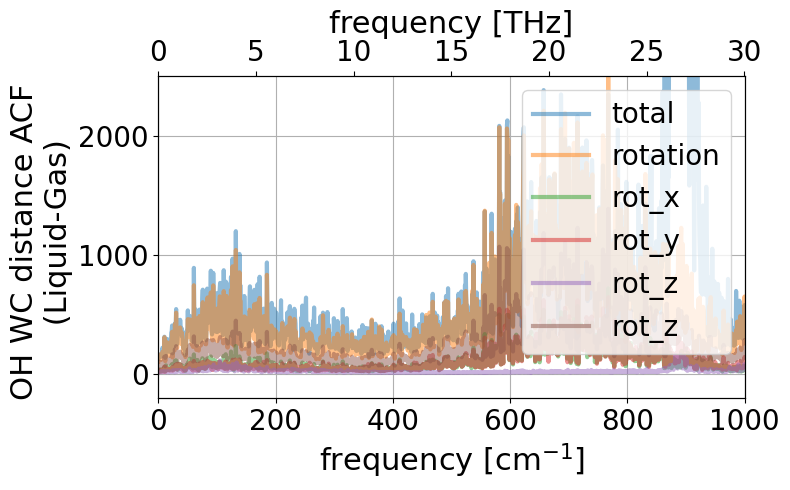

In [123]:
#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画


# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画


ax.plot(rfreq*33.3, alphan_total, alpha=0.5, label="total", lw=3)  # 描画
ax.plot(rfreq*33.3, alphan_rotation, alpha=0.5, label="rotation", lw=3)  # 描画
ax.plot(rfreq*33.3, alphan_rotation_x, alpha=0.5, label="rot_x", lw=3)  # 描画
ax.plot(rfreq*33.3, alphan_rotation_y, alpha=0.5, label="rot_y", lw=3)  # 描画
ax.plot(rfreq*33.3, alphan_rotation_z, alpha=0.5, label="rot_z", lw=3)  # 描画
ax.plot(rfreq*33.3, alphan_rotation_x+alphan_rotation_y+alphan_rotation_z, alpha=0.5, label="rot_z", lw=3)  # 描画



# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=1000

ax.set_xlim(0,XMAX)
ax.set_ylim(-200,2500)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



In [127]:
#
# * traj読み込み
# * coord計算
# * 分子双極子読み込み
# * 座標計算
# * diel計算

class test:
    def __init__(self,traj,mol_dipole,NUM_MOL:int,name:str):
        self._traj = traj
        self._mol_dipole = mol_dipole
        self.NUM_MOL = NUM_MOL
        self.LEN = len(self._traj)
        self.name = name
        
    def process(self):
        # coord計算
        coord_inertia, inertia_axis, inertia_eigenval = calc_inertia_traj(self._traj)
        # 座標計算
        mol_dipole_inertia_list = np.empty([len(traj_liquid),self.NUM_MOL,3])

        # mol_dipole_inertia_list
        for counter in range(self.LEN): # frameに関するloop 
            for mol_id in range(self.NUM_MOL): # 分子数に関するloop
                mol_dipole_inertia_list[counter,mol_id] = np.einsum("i,ki->k",self._mol_dipole[counter,mol_id],inertia_axis[counter,mol_id])

        # 軸に沿った分子双極子リスト
        # * 各軸x,y,zに沿った分子双極子のリストを作成
        mol_dipole_inertia_x = np.empty([self.LEN,self.NUM_MOL,3])
        mol_dipole_inertia_y = np.empty([self.LEN,self.NUM_MOL,3])
        mol_dipole_inertia_z = np.empty([self.LEN,self.NUM_MOL,3])

        for counter in range(self.LEN): # frameに関するloop 
            for mol_id in range(self.NUM_MOL): # 分子数に関するloop
                mol_dipole_inertia_x[counter,mol_id] = mol_dipole_inertia_list[counter,mol_id,0]*inertia_axis[counter,mol_id,0]
                mol_dipole_inertia_y[counter,mol_id] = mol_dipole_inertia_list[counter,mol_id,1]*inertia_axis[counter,mol_id,1]
                mol_dipole_inertia_z[counter,mol_id] = mol_dipole_inertia_list[counter,mol_id,2]*inertia_axis[counter,mol_id,2]
        #
        # * 分子についての輪をとる
        self._total_dipole_inertia_x = np.sum(mol_dipole_inertia_x,axis=1)
        self._total_dipole_inertia_y = np.sum(mol_dipole_inertia_y,axis=1)
        self._total_dipole_inertia_z = np.sum(mol_dipole_inertia_z,axis=1)
    
    def postprocess(self):
        # self成分
        rfreq,x_eps1_list,x_eps2_list = calc_self_diel(self._total_dipole_inertia_x)
        rfreq,y_eps1_list,y_eps2_list = calc_self_diel(self._total_dipole_inertia_y)
        rfreq,z_eps1_list,z_eps2_list = calc_self_diel(self._total_dipole_inertia_z)
        # cross成分
        rfreq,cross_xy_eps1_list,cross_xy_eps2_list = calc_cross_diel(self._total_dipole_inertia_x,self._total_dipole_inertia_y)
        rfreq,cross_xz_eps1_list,cross_xz_eps2_list = calc_cross_diel(self._total_dipole_inertia_x,self._total_dipole_inertia_z)
        rfreq,cross_yz_eps1_list,cross_yz_eps2_list = calc_cross_diel(self._total_dipole_inertia_y,self._total_dipole_inertia_z)
        # total成分
        rfreq,total_eps1_list,total_eps2_list = calc_self_diel(self._total_dipole_inertia_x+self._total_dipole_inertia_y+self._total_dipole_inertia_z)

        # df作成        
        self.df_total    = make_pd(rfreq,total_eps1_list,total_eps2_list,f"20240218_total_{self.name}_diel.csv")
        self.df_x        = make_pd(rfreq,x_eps1_list,x_eps2_list,f"20240218_x_{self.name}_diel.csv")
        self.df_y        = make_pd(rfreq,y_eps1_list,y_eps2_list,f"20240218_y_{self.name}_diel.csv")
        self.df_z        = make_pd(rfreq,z_eps1_list,z_eps2_list,f"20240218_z_{self.name}_diel.csv")
        self.df_xy_cross = make_pd(rfreq,cross_xy_eps1_list,cross_xy_eps2_list,f"20240218_cross_xy_{self.name}_diel.csv")
        self.df_xz_cross = make_pd(rfreq,cross_xz_eps1_list,cross_xz_eps2_list,f"20240218_cross_xz_{self.name}_diel.csv")
        self.df_yz_cross = make_pd(rfreq,cross_yz_eps1_list,cross_yz_eps2_list,f"20240218_cross_yz_{self.name}_diel.csv")


In [28]:
NUM_MOL=48
traj_list = []
traj_list.append(ase.io.read("../traj/mol_wan_1.xyz",index="600:100600"))
traj_list.append(ase.io.read("../traj/mol_wan_3.xyz",index="600:100600"))
traj_list.append(ase.io.read("../traj/mol_wan_6.xyz",index="6000:106000"))
traj_list.append(ase.io.read("../traj/mol_wan_7.xyz",index="100000:200000"))
traj_list.append(ase.io.read("../traj/mol_wan_8.xyz",index="100000:200000"))
traj_list.append(ase.io.read("../traj/mol_wan_7.xyz",index=":100000"))
traj_list.append(ase.io.read("../traj/mol_wan_8.xyz",index=":100000"))

dipole_list = []
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_1.txt")[:,2:].reshape(-1,NUM_MOL,3)[600:100600])
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_3.txt")[:,2:].reshape(-1,NUM_MOL,3)[600:100600])
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_6.txt")[:,2:].reshape(-1,NUM_MOL,3)[6000:106000])
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_7.txt")[:,2:].reshape(-1,NUM_MOL,3)[100000:200000])
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_8.txt")[:,2:].reshape(-1,NUM_MOL,3)[100000:200000])
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_7.txt")[:,2:].reshape(-1,NUM_MOL,3)[:100000])
dipole_list.append(np.loadtxt("../molecule_dipole/molecule_dipole_8.txt")[:,2:].reshape(-1,NUM_MOL,3)[:100000])


In [42]:
result = []
counter = [1,3,6,7,8,9,10]
for traj,mol_dipole,index in zip(traj_list,dipole_list,counter):
    print(index)
    test1=test(traj,mol_dipole,NUM_MOL=48,name=str(index))
    test1.process()
    test1.postprocess()
    result.append(test1)

1
3
6
7
8
9
10


In [45]:
#
# * 計算したスペクトルを平均化する

def calc_average(name:str="20240218_total_"):
    import pandas as pd

    dataframe_list = []
    for index in counter:
        dataframe_list.append(pd.read_csv(f"{name}{index}_diel.csv"))
    # https://stackoverflow.com/questions/25057835/get-the-mean-across-multiple-pandas-dataframes
    df_concat = pd.concat((dataframe_list[0], dataframe_list[1],dataframe_list[2],dataframe_list[3],dataframe_list[4],dataframe_list[5],dataframe_list[6]))
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    df_means.to_csv(f"{name}_diel.csv")
    return df_means

In [46]:
df_total    = calc_average(f"20240218_total_")
df_x        = calc_average(f"20240218_x__")
df_y        = calc_average(f"20240218_y__")
df_z        = calc_average(f"20240218_z__")
df_xy_cross = calc_average(f"20240218_cross_xy__")
df_xz_cross = calc_average(f"20240218_cross_xz__")
df_yz_cross = calc_average(f"20240218_cross_yz__")

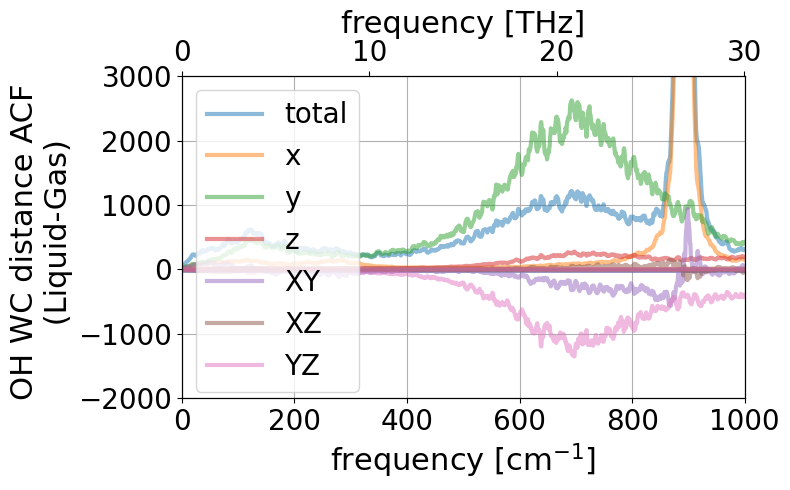

In [47]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_x["alphan"], alpha=0.5, label="x", lw=3)  # 描画
ax.plot(df_y["rfreq"]*33.3, df_y["alphan"], alpha=0.5, label="y", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_z["alphan"], alpha=0.5, label="z", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xy_cross["alphan"], alpha=0.5, label="XY", lw=3)  # 描画
ax.plot(df_xz_cross["rfreq"]*33.3, df_xz_cross["alphan"], alpha=0.5, label="XZ", lw=3)  # 描画
ax.plot(df_yz_cross["rfreq"]*33.3, df_yz_cross["alphan"], alpha=0.5, label="YZ", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=1000

ax.set_xlim(0,XMAX)
ax.set_ylim(-2000,3000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper left",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



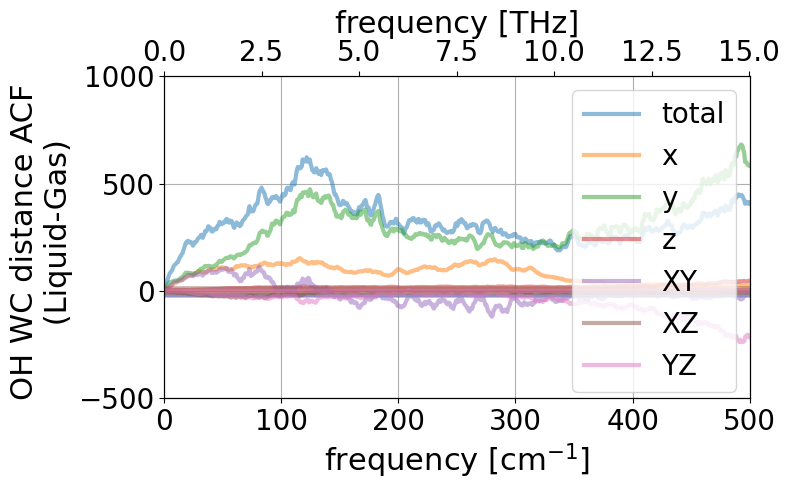

In [48]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_x["alphan"], alpha=0.5, label="x", lw=3)  # 描画
ax.plot(df_y["rfreq"]*33.3, df_y["alphan"], alpha=0.5, label="y", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_z["alphan"], alpha=0.5, label="z", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xy_cross["alphan"], alpha=0.5, label="XY", lw=3)  # 描画
ax.plot(df_xz_cross["rfreq"]*33.3, df_xz_cross["alphan"], alpha=0.5, label="XZ", lw=3)  # 描画
ax.plot(df_yz_cross["rfreq"]*33.3, df_yz_cross["alphan"], alpha=0.5, label="YZ", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=500

ax.set_xlim(0,XMAX)
ax.set_ylim(-500,1000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])

# 以前の解析だと，液体モデルではxが260cm-1にピーク．yが120cm-1にピーク

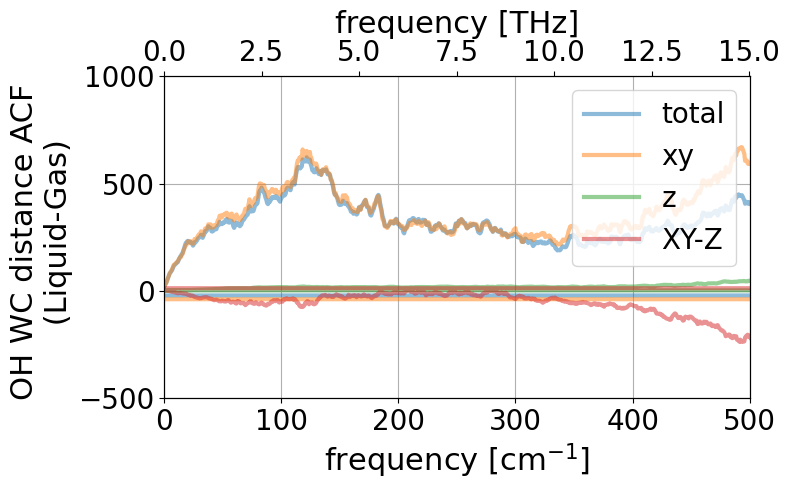

In [51]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_x["alphan"]+df_y["alphan"]+df_xy_cross["alphan"], alpha=0.5, label="xy", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_z["alphan"], alpha=0.5, label="z", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xz_cross["alphan"]+df_yz_cross["alphan"], alpha=0.5, label="XY-Z", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=500

ax.set_xlim(0,XMAX)
ax.set_ylim(-500,1000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



# 
# 分子双極子を読み込む

In [8]:
# liquidのデータを読み込み（128分子分）
NUM_MOL=48
mol_dipole_liquid = np.loadtxt("../molecule_dipole/molecule_dipole_1.txt")[:,2:].reshape(-1,NUM_MOL,3)[600:100600]
print(np.shape(mol_dipole_liquid))

(100000, 48, 3)


In [9]:
#
# * 分子双極子の座標変換（主慣性軸）

mol_dipole_inertia_list = np.empty([len(traj_liquid),NUM_MOL,3])

for counter,atoms in enumerate(traj_liquid): # frameに関するloop 
    for mol_id in range(NUM_MOL): # 分子数に関するloop
        # !! ここで双極子ベクトルを規格化する必要があるかどうか？ -> 規格化してもしなくても結果は同じだった．
        # step counterでの分子双極子のinertia_axisへ向けた座標
        mol_dipole_inertia_list[counter,mol_id] = np.einsum("i,ki->k",mol_dipole_liquid[counter,mol_id],inertia_axis[counter,mol_id])


In [10]:
#
# * 各軸x,y,zに沿った分子双極子のリストを作成
mol_dipole_inertia_x = np.empty([len(traj_liquid),NUM_MOL,3])
mol_dipole_inertia_y = np.empty([len(traj_liquid),NUM_MOL,3])
mol_dipole_inertia_z = np.empty([len(traj_liquid),NUM_MOL,3])


for counter,atoms in enumerate(traj_liquid): # frameに関するloop 
    for mol_id in range(NUM_MOL): # 分子数に関するloop
        # !! ここで双極子ベクトルを規格化する必要があるかどうか？ -> 規格化してもしなくても結果は同じだった．
        # step counterでの分子双極子のinertia_axisへ向けた座標
        mol_dipole_inertia_x[counter,mol_id] = mol_dipole_inertia_list[counter,mol_id,0]*inertia_axis[counter,mol_id,0]
        mol_dipole_inertia_y[counter,mol_id] = mol_dipole_inertia_list[counter,mol_id,1]*inertia_axis[counter,mol_id,1]
        mol_dipole_inertia_z[counter,mol_id] = mol_dipole_inertia_list[counter,mol_id,2]*inertia_axis[counter,mol_id,2]

In [11]:
#
# * 分子についての輪をとる
total_dipole_inertia_x = np.sum(mol_dipole_inertia_x,axis=1)
total_dipole_inertia_y = np.sum(mol_dipole_inertia_y,axis=1)
total_dipole_inertia_z = np.sum(mol_dipole_inertia_z,axis=1)

In [19]:
#
# * 
# acf
#
# * 自己相関成分

from ml.acf_fourier import dielec
from ml.acf_fourier import calc_cross_acf


# process = dielec(UNITCELL_VECTORS=traj_liquid[0].get_cell(), TEMPERATURE=300, TIMESTEP=0.484)
def calc_self_diel(frame_dipole):
    process = dielec(UNITCELL_VECTORS=traj_liquid[0].get_cell(), TEMPERATURE=300, TIMESTEP=0.484)
    rfreq, ffteps1,ffteps2 = process.calc_fourier(frame_dipole,eps_n2=1.76624,window="hann")
    return rfreq, ffteps1, ffteps2

def calc_cross_diel(frame_dipole1,frame_dipole2):
    process = dielec(UNITCELL_VECTORS=traj_liquid[0].get_cell(), TEMPERATURE=300, TIMESTEP=0.484)
    # cross correlationの計算
    acf_x,acf_y,acf_z    = calc_cross_acf(frame_dipole1,frame_dipole2,engine="tsa")
    acf_x2,acf_y2,acf_z2 = calc_cross_acf(frame_dipole2,frame_dipole1,engine="tsa")    
    # acfは 足し合わせてdielec.calc_fourier_only_with_windowに入れる
    rfreq, ffteps1, ffteps2 = process.calc_fourier_only_with_window(acf_x+acf_y+acf_z+acf_x2+acf_y2+acf_z2,eps_n2=1.76624,window="hann")
    return rfreq, ffteps1, ffteps2



# self成分
rfreq,x_eps1_list,x_eps2_list = calc_self_diel(total_dipole_inertia_x)
rfreq,y_eps1_list,y_eps2_list = calc_self_diel(total_dipole_inertia_y)
rfreq,z_eps1_list,z_eps2_list = calc_self_diel(total_dipole_inertia_z)
# cross成分
rfreq,cross_xy_eps1_list,cross_xy_eps2_list = calc_cross_diel(total_dipole_inertia_x,total_dipole_inertia_y)
rfreq,cross_xz_eps1_list,cross_xz_eps2_list = calc_cross_diel(total_dipole_inertia_x,total_dipole_inertia_z)
rfreq,cross_yz_eps1_list,cross_yz_eps2_list = calc_cross_diel(total_dipole_inertia_y,total_dipole_inertia_z)
# total成分
rfreq,total_eps1_list,total_eps2_list = calc_self_diel(total_dipole_inertia_x+total_dipole_inertia_y+total_dipole_inertia_z)


# pdへ落とし込み
import pandas as pd

# pd作成用
def make_pd(rfreq,eps1_list,eps2_list,name:str,window_size:int= 10):
    window = np.ones(window_size)/window_size
    import pandas as pd
    df = pd.DataFrame()
    df["rfreq"] = rfreq
    df["kayser_freq"] = rfreq*33.3
    df["realdiel"] = eps1_list
    df["imagdiel"] = eps2_list
    df["alphan"]   = np.convolve(df["imagdiel"]*df["rfreq"]*200*3.14/3,window,mode="same")
    df.to_csv(name)
    return df

df_total = make_pd(rfreq,total_eps1_list,total_eps2_list,"20240218_total_diel.csv")
df_x   = make_pd(rfreq,x_eps1_list,x_eps2_list,"20240218_x_diel.csv")
df_y    = make_pd(rfreq,y_eps1_list,y_eps2_list,"20240218_y_diel.csv")
df_z    = make_pd(rfreq,z_eps1_list,z_eps2_list,"20240218_z_diel.csv")
df_xy_cross = make_pd(rfreq,cross_xy_eps1_list,cross_xy_eps2_list,"20240218_cross_xy_diel.csv")
df_xz_cross = make_pd(rfreq,cross_xz_eps1_list,cross_xz_eps2_list,"20240218_cross_xz_diel.csv")
df_yz_cross  = make_pd(rfreq,cross_yz_eps1_list,cross_yz_eps2_list,"20240218_cross_yz_diel.csv")


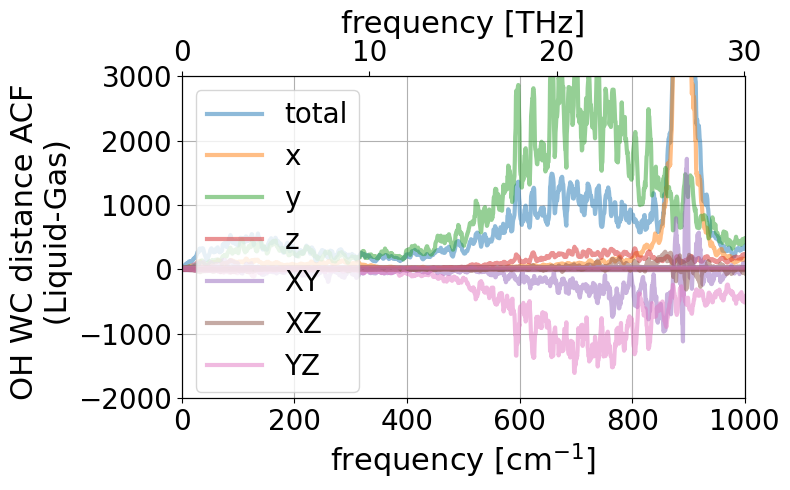

In [24]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_x["alphan"], alpha=0.5, label="x", lw=3)  # 描画
ax.plot(df_y["rfreq"]*33.3, df_y["alphan"], alpha=0.5, label="y", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_z["alphan"], alpha=0.5, label="z", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xy_cross["alphan"], alpha=0.5, label="XY", lw=3)  # 描画
ax.plot(df_xz_cross["rfreq"]*33.3, df_xz_cross["alphan"], alpha=0.5, label="XZ", lw=3)  # 描画
ax.plot(df_yz_cross["rfreq"]*33.3, df_yz_cross["alphan"], alpha=0.5, label="YZ", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=1000

ax.set_xlim(0,XMAX)
ax.set_ylim(-2000,3000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper left",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



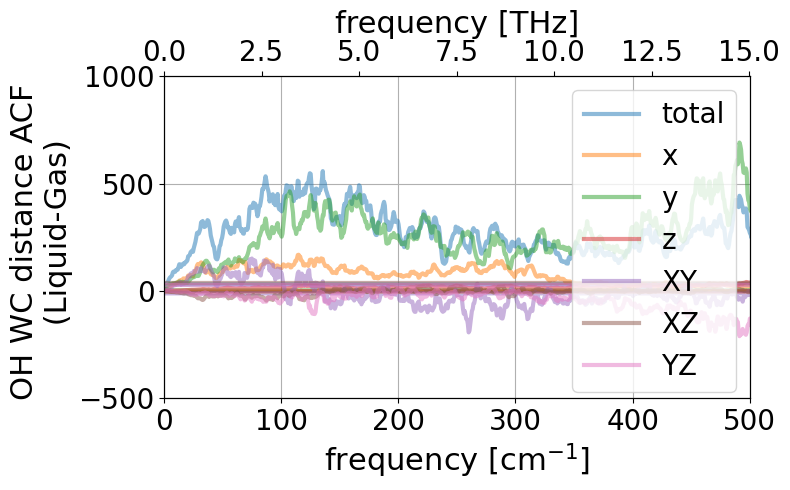

In [22]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_x["alphan"], alpha=0.5, label="x", lw=3)  # 描画
ax.plot(df_y["rfreq"]*33.3, df_y["alphan"], alpha=0.5, label="y", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_z["alphan"], alpha=0.5, label="z", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xy_cross["alphan"], alpha=0.5, label="XY", lw=3)  # 描画
ax.plot(df_xz_cross["rfreq"]*33.3, df_xz_cross["alphan"], alpha=0.5, label="XZ", lw=3)  # 描画
ax.plot(df_yz_cross["rfreq"]*33.3, df_yz_cross["alphan"], alpha=0.5, label="YZ", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=500

ax.set_xlim(0,XMAX)
ax.set_ylim(-500,1000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



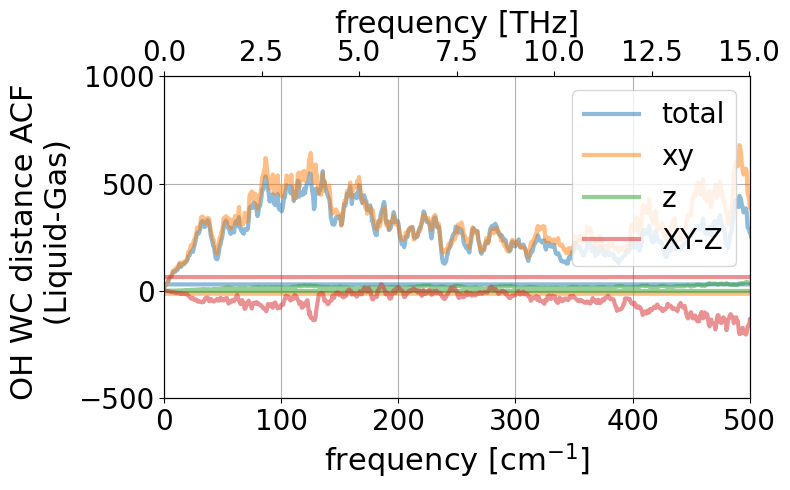

In [25]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_x["alphan"]+df_y["alphan"]+df_xy_cross["alphan"], alpha=0.5, label="xy", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_z["alphan"], alpha=0.5, label="z", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xz_cross["alphan"]+df_yz_cross["alphan"], alpha=0.5, label="XY-Z", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=500

ax.set_xlim(0,XMAX)
ax.set_ylim(-500,1000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



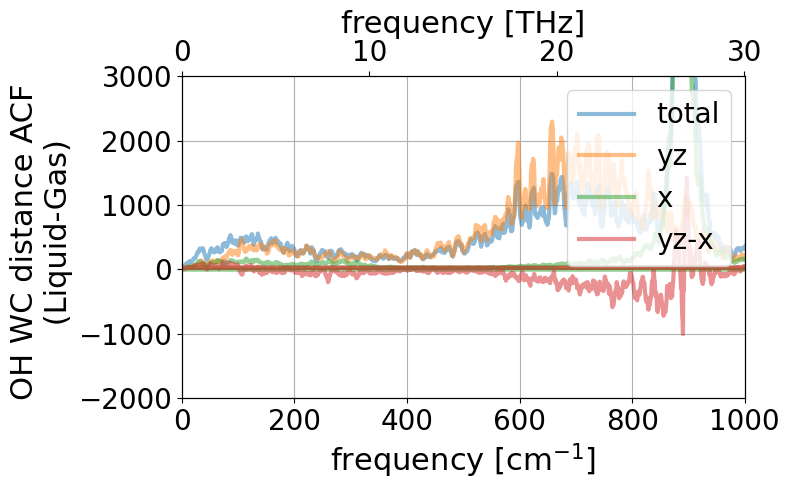

In [27]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(df_total["rfreq"]*33.3, df_total["alphan"], alpha=0.5, label="total", lw=3)  # 描画

ax.plot(df_x["rfreq"]*33.3, df_y["alphan"]+df_z["alphan"]+df_yz_cross["alphan"], alpha=0.5, label="yz", lw=3)  # 描画
ax.plot(df_z["rfreq"]*33.3, df_x["alphan"], alpha=0.5, label="x", lw=3)  # 描画

ax.plot(df_xy_cross["rfreq"]*33.3, df_xz_cross["alphan"]+df_xy_cross["alphan"], alpha=0.5, label="yz-x", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="OH WC distance ACF \n (Liquid-Gas)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=1000

ax.set_xlim(0,XMAX)
ax.set_ylim(-2000,3000)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



In [131]:


mol_dipole_angular_velocity_list = np.empty([len(traj_liquid)-1,NUM_MOL,3])


mol_dipole_theta_list = np.empty([len(traj_liquid)-1,NUM_MOL])
Dt=0.484

for counter,atoms in enumerate(traj_liquid): # frameに関するloop 
    if counter == len(traj_liquid)-1: #最終フレームはskip
        break
    for mol_id in range(NUM_MOL): # 分子数に関するloop
        # !! ここで双極子ベクトルを規格化する必要があるかどうか？ -> 規格化してもしなくても結果は同じだった．
        # step counterでの分子双極子のinertia_axisへ向けた座標
        dipole_inertia_start = np.einsum("i,ki->k",mol_dipole_liquid[counter,mol_id]/np.linalg.norm(mol_dipole_liquid[counter,mol_id]),inertia_axis[counter,mol_id])
        # step counter+1での分子双極子のinertia_axisへ向けた座標
        dipole_inertia_end   = np.einsum("i,ki->k",mol_dipole_liquid[counter+1,mol_id]/np.linalg.norm(mol_dipole_liquid[counter+1,mol_id]),inertia_axis[counter,mol_id])
        # 二つのベクトルから，各軸周りの角速度を計算        
        # >>>>>>>>>>>>>>>>>>>>>>>>>
        # テストとして，arccosを計算する (purdue2006Comparative)
        theta_start = np.arccos(dipole_inertia_start/np.linalg.norm(dipole_inertia_start))
        theta_end   = np.arccos(dipole_inertia_end/np.linalg.norm(dipole_inertia_end))
        diff_theta   = (theta_start-theta_end)/Dt
        # >>>>>>>>>>>>>>>>>>>>>>>>>
        # x軸(CO)周りの振動(yz平面) → これは完全に~300cm-1ではピークが出てこないので無視してOK．
        # 一方，600~800cm-1に大きなピークを持つ
        # 正しい順番は2,1
        theta_t    = np.arctan2(dipole_inertia_start[2],dipole_inertia_start[1]) # y,xの順で値を与える
        theta_t_dt = np.arctan2(dipole_inertia_end[2],dipole_inertia_end[1]) # y,xの順で値を与える
        # arccosによる計算
        # theta_t    = np.arccos(dipole_inertia_start[1]/np.sqrt(dipole_inertia_start[1]**2+dipole_inertia_start[2]**2))
        # theta_t_dt = np.arccos(dipole_inertia_end[1]/np.sqrt(dipole_inertia_end[1]**2+dipole_inertia_end[2]**2))
        # logger.debug("theta_t :: {0}".format(theta_t))        
        # 各原子の角速度
        angular_velocity = (theta_t_dt-theta_t)/Dt
        # logger.debug("angular_velocity :: {0}".format(angular_velocity))
        # arctanからの計算
        mol_dipole_angular_velocity_list[counter,mol_id,0] = angular_velocity* 180/np.pi
        # arccosからの計算
        # mol_dipole_angular_velocity_list[counter,mol_id,0] = diff_theta[0] * 180/np.pi
        # >>>>>>>>>>>>>>>>>>>>>>>>>
        # y軸(//OH)周りの振動(zx平面)
        # TODO :: なぜこのy軸周り振動が120cm-1にピークを持つのかを知りたい．
        # TODO :: どの原子のスペクトルなのかを調べる．
        # TODO :: 現状，0,2で変数を与えるとうまくいく（x,zだから，順番としては正しい）
        theta_t    = np.arctan2(dipole_inertia_start[0],dipole_inertia_start[2]) 
        theta_t_dt = np.arctan2(dipole_inertia_end[0],dipole_inertia_end[2]) # 
        # arccosの欠点は，[0,pi]で与えられること
        # theta_t_2    = np.arccos(dipole_inertia_start[2]/np.sqrt(dipole_inertia_start[0]**2+dipole_inertia_start[2]**2))
        # theta_t_dt = np.arccos(dipole_inertia_end[2]/np.sqrt(dipole_inertia_end[0]**2+dipole_inertia_end[2]**2))
        # logger.debug("theta_t :: {0}".format(theta_t))        
        # 各原子の角速度
        angular_velocity = (theta_t_dt-theta_t)/Dt
        # logger.debug("angular_velocity :: {0}".format(angular_velocity))
        # 
        mol_dipole_angular_velocity_list[counter,mol_id,1] = angular_velocity* 180/np.pi
        # mol_dipole_angular_velocity_list[counter,mol_id,1] = diff_theta[1] * 180/np.pi


        # >>>>>>>>>>>>>>>>>>>>>>>>>
        # TODO :: 0,1の順で与えるか1,0の順で与えるかで結果がすごい変わってしまう．
        # TODO :: 現状，0,1で与えるとちゃんとピークが出る．
        # z軸周りの振動=in plane振動(xy平面) -> これが120cm-1にピークを持って欲しい
        theta_t    = np.arctan2(dipole_inertia_start[0],dipole_inertia_start[1])  # y,xで値を与える
        theta_t_dt = np.arctan2(dipole_inertia_end[0],dipole_inertia_end[1]) # 
        # logger.debug("theta_t :: {0}".format(theta_t))        
        # 各原子の角速度
        angular_velocity = (theta_t_dt-theta_t)/Dt
        # logger.debug("angular_velocity :: {0}".format(angular_velocity))
        # 
        mol_dipole_angular_velocity_list[counter,mol_id,2] = angular_velocity * 180/np.pi
        # mol_dipole_angular_velocity_list[counter,mol_id,2] = diff_theta[2] * 180/np.pi
        mol_dipole_theta_list[counter,mol_id] = theta_t 



In [132]:

import statsmodels.api as sm
import numpy as np

# * acfを計算する．
acf_x = np.zeros(len(traj_liquid)-1)
acf_y = np.zeros(len(traj_liquid)-1)
acf_z = np.zeros(len(traj_liquid)-1)

for mol_id in range(NUM_MOL):
    # acf_x += sm.tsa.stattools.acf(mol_dipole_angular_velocity_list[:,mol_id,0],fft=True,nlags=len(traj_liquid)-1)*np.std(mol_dipole_angular_velocity_list[:,mol_id,0])*np.std(mol_dipole_angular_velocity_list[:,mol_id,0]) # 正規化される
    # acf_y += sm.tsa.stattools.acf(mol_dipole_angular_velocity_list[:,mol_id,1],fft=True,nlags=len(traj_liquid)-1)*np.std(mol_dipole_angular_velocity_list[:,mol_id,1])*np.std(mol_dipole_angular_velocity_list[:,mol_id,1])  # 正規化される
    # acf_z += sm.tsa.stattools.acf(mol_dipole_angular_velocity_list[:,mol_id,2],fft=True,nlags=len(traj_liquid)-1)*np.std(mol_dipole_angular_velocity_list[:,mol_id,2])*np.std(mol_dipole_angular_velocity_list[:,mol_id,2])  # 正規化される

    # 規格化した場合
    acf_x += sm.tsa.stattools.acf(mol_dipole_angular_velocity_list[:,mol_id,0],fft=True,nlags=len(traj_liquid)-1)
    acf_y += sm.tsa.stattools.acf(mol_dipole_angular_velocity_list[:,mol_id,1],fft=True,nlags=len(traj_liquid)-1)
    acf_z += sm.tsa.stattools.acf(mol_dipole_angular_velocity_list[:,mol_id,2],fft=True,nlags=len(traj_liquid)-1)


# !! 角速度に関しては，omegaをかけるのと書けないのとで大した差はない．
# !! 従って，この計算はそこそこ正しい線行っていると思われる．
# !! 計算上は当然omegaをかけない方が正しい．

# omegaをかけない方
fftvdos_x = calc_angular_vdos(acf_x)
fftvdos_y = calc_angular_vdos(acf_y)
fftvdos_z = calc_angular_vdos(acf_z)

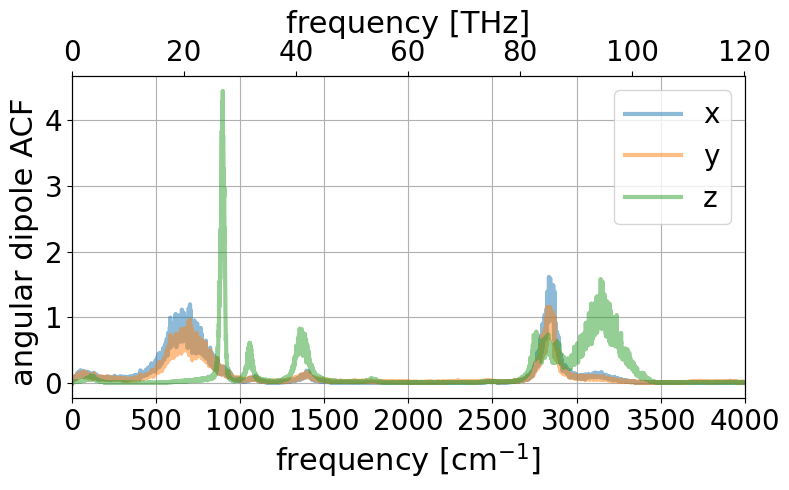

In [133]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(fftvdos_x[0]*33.3, fftvdos_x[1], alpha=0.5, label="x", lw=3)  # 描画
ax.plot(fftvdos_x[0]*33.3, fftvdos_y[1], alpha=0.5, label="y", lw=3)  # 描画
ax.plot(fftvdos_x[0]*33.3, fftvdos_z[1], alpha=0.5, label="z", lw=3)  # 描画


# exp
# ax.scatter(expdata_eps1[:,0], expdata_eps1[:,1], label="Exp.", lw=3)  # 描画
# ax.scatter(expdata_eps2[:,0], expdata_eps2[:,1], label="Exp.", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="angular dipole ACF "
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=4000

ax.set_xlim(0,XMAX)
# ax.set_ylim(0.0,10)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])

